# Imports & Data Download

In [ ]:
# TODO: Change filepath to location of numpy files containing model generated 
# summaries.
DATA_LOCATION = '.'

In [ ]:
!pip install rouge_score

from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from datasets import load_dataset
import nltk
nltk.download("wordnet")
nltk.download("punkt")
from nltk.translate.meteor_score import meteor_score

from pathlib import Path
import numpy as np
import scipy.stats as stats
import pandas as pd
from collections import Counter

In [ ]:
ds = load_dataset("ccdv/pubmed-summarization", "section")

In [4]:
num_papers = 200
abstracts = ds['test']['abstract'][:num_papers]

# Score Functions

In [ ]:
eval_model = SentenceTransformer('all-mpnet-base-v2')

#
# Sentence transformation model which generates embeddings of the model
# summary and the ground truth abstract. Return cosine similarity of the two
# embeddings.
#
def embed_similarity(model_summary, abstract):
  texts = [model_summary, abstract]
  embeddings = eval_model.encode(texts, convert_to_tensor=True)
  similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
  return similarity

In [7]:
#
# Return cosine similarity using tf-idf vectorizer on texts.
#
def tfidf_similarity(model_summary, abstract):
  vectorizer = TfidfVectorizer(stop_words='english')  # Removes common words such as "the"
  tfidf_matrix = vectorizer.fit_transform([model_summary, abstract])
  similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
  return similarity

In [9]:
#
# Return BLEU score between model's summary and the abstract. Code adapted from:
# https://medium.com/@diwakarkumar_18755/easy-guide-to-rouge-bleu-and-meteor-metrics-to-evaluate-llm-outputs-7afa5a3e1ca3
#
def bleu(model_summary, abstract):
  summary_words = model_summary.lower().split()
  abstract_words = abstract.lower().split()
  summary_unigrams = Counter(summary_words)
  abstract_unigrams = Counter(abstract_words)

  # Count overlapping unigrams
  match = sum(min(abstract_unigrams[bg], summary_unigrams.get(bg, 0)) for bg in abstract_unigrams)
  precision = match / max(1, sum(abstract_unigrams.values()))
  return precision

In [10]:
def rouge1(model_summary, abstract):
  rouge = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)
  scores = rouge.score(model_summary, abstract)
  return scores["rouge1"].fmeasure

def rouge2(model_summary, abstract):
  rouge = rouge_scorer.RougeScorer(["rouge2"], use_stemmer=True)
  scores = rouge.score(model_summary, abstract)
  return scores["rouge2"].fmeasure

def rougeL_precision(model_summary, abstract):
    scores = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)\
             .score(model_summary, abstract)["rougeLsum"]
    return scores.precision

def rougeL_recall(model_summary, abstract):
    scores = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)\
             .score(model_summary, abstract)["rougeLsum"]
    return scores.recall

def rougeL_f1(model_summary, abstract):
    scores = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)\
             .score(model_summary, abstract)["rougeLsum"]
    return scores.fmeasure

In [11]:
def vectorize(model_summary, abstract):
  model_summary_tokens = model_summary.lower().split()
  abstract_tokens = abstract.lower().split()
  vocab = list(set(model_summary_tokens + abstract_tokens))
  model_summary_vec = np.array([1 if w in model_summary_tokens else 0 for w in vocab])
  abstract_vec = np.array([1 if w in abstract_tokens else 0 for w in vocab])
  return model_summary_vec, abstract_vec

def precision(model_summary, abstract):
  model_summary_vec, abstract_vec = vectorize(model_summary, abstract)

  if model_summary_vec.sum() == 0 or abstract_vec.sum() == 0:
      return 0
  return precision_score(model_summary_vec, abstract_vec, zero_division=0)

def recall(model_summary, abstract):
  model_summary_vec, abstract_vec = vectorize(model_summary, abstract)

  if model_summary_vec.sum() == 0 or abstract_vec.sum() == 0:
      return 0
  return recall_score(model_summary_vec, abstract_vec, zero_division=0)

def f1(model_summary, abstract):
  model_summary_vec, abstract_vec = vectorize(model_summary, abstract)

  if model_summary_vec.sum() == 0 or abstract_vec.sum() == 0:
      return 0
  return f1_score(model_summary_vec, abstract_vec, zero_division=0)


In [12]:
def meteor(model_summary, abstract):
    abstract_tokens = abstract.lower().split()
    model_summary_tokens = model_summary.lower().split()

    # meteor_score expects: meteor_score([ref1_tokens], hyp_tokens)
    return meteor_score([abstract_tokens], model_summary_tokens)

In [13]:
#
# Receive list of model summaries and calculate score of each model summary
# given the score function defined above (similarity_func). For the entire list
# of model summaries, return the mean, lower confidence interval level, upper
# confidence interval level, and the standard deviation.
#
def generate_results(summaries, similarity_func, cl=0.95):
  similarities = [similarity_func(summaries[i], abstracts[i]) for i in range(num_papers)]
  ci = stats.t.interval(cl, df=len(similarities)-1, loc=np.mean(similarities), scale=np.std(similarities, ddof=1) / np.sqrt(len(similarities)))
  return np.mean(similarities), ci[0], ci[1], np.std(similarities)


# Generate Results and Graph

In [ ]:
directory_path = Path(DATA_LOCATION)
files = [item.name for item in directory_path.iterdir() if item.is_file()]
# Map name of score to score function defined in above cells.
metrics = {
           'Embedding Similarity': embed_similarity,
           'TF-IDF Similarity': tfidf_similarity,
           'ROUGE-1': rouge1,
           'ROUGE-2': rouge2,
           'ROUGE-L Precision': rougeL_precision,
           'ROUGE-L Recall': rougeL_recall,
           'ROUGE-L F1': rougeL_f1,
           'Precision': precision,
           'Recall': recall,
           'F1': f1,
           'BLEU': bleu,
           'METEOR': meteor
}
all_model_results = dict()

model_techniques = []

for f in files:
  if f[-4:] != '.npy': continue
  technique = f.split('_')[0]
  print(technique)
  model_techniques.append(technique)

  summaries = np.load(DATA_LOCATION+f, allow_pickle=True)
  print(summaries.shape)
  if summaries.shape != (200,):
    print(f'{f}\'s matrix has incorrect shape. It needs to be {(num_papers,)}, but it has shape {summaries.shape}')
    continue

  model_results = [] # Each metric occupies a dimension in a tuple: (mean, 95% LCL, 95% UCL, SD)
  for score, score_func in metrics.items():
    result = generate_results(summaries, score_func)
    model_results.append(result)
  all_model_results[technique] = model_results

In [21]:
means = {}
raw_means = {}
sds = {}
for model, results in all_model_results.items():
  means[model] = []
  raw_means[model] = []
  sds[model] = []
  for metric in results:
    means[model].append(f'{round(metric[0], 3)} ({round(metric[1], 3)}, {round(metric[2], 3)})')
    sds[model].append(f'{round(metric[3], 3)}')
    raw_means[model].append(f'{round(metric[0], 3)}')

In [22]:
df_mean = pd.DataFrame.from_dict(means, orient = 'index', columns = metrics.keys())
print('Mean:')
display(df_mean)

print()

df_sd = pd.DataFrame.from_dict(sds, orient = 'index', columns = metrics.keys())
print('Standard Deviation:')
display(df_sd)

Mean:


,Embedding Similarity,TF-IDF Similarity,ROUGE-1,ROUGE-2,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1,Precision,Recall,F1,BLEU,METEOR
T5 Baseline,"0.673 (0.653, 0.694)","0.175 (0.155, 0.195)","0.231 (0.215, 0.246)","0.083 (0.068, 0.099)","0.126 (0.115, 0.138)","0.401 (0.375, 0.426)","0.183 (0.168, 0.197)","0.164 (0.152, 0.176)","0.406 (0.382, 0.43)","0.226 (0.212, 0.241)","0.134 (0.123, 0.145)","0.101 (0.091, 0.111)"
Fully Finetuned,"0.82 (0.805, 0.836)","0.279 (0.256, 0.303)","0.372 (0.356, 0.389)","0.151 (0.132, 0.17)","0.244 (0.229, 0.26)","0.352 (0.329, 0.374)","0.274 (0.258, 0.291)","0.286 (0.271, 0.3)","0.429 (0.407, 0.452)","0.332 (0.316, 0.348)","0.284 (0.27, 0.298)","0.202 (0.189, 0.215)"
One-shot Prompting,"0.675 (0.651, 0.698)","0.204 (0.188, 0.221)","0.253 (0.24, 0.266)","0.077 (0.069, 0.086)","0.134 (0.125, 0.142)","0.365 (0.346, 0.384)","0.187 (0.177, 0.197)","0.196 (0.185, 0.207)","0.491 (0.471, 0.511)","0.268 (0.255, 0.28)","0.189 (0.178, 0.199)","0.132 (0.125, 0.14)"
Retrieval,"0.561 (0.533, 0.59)","0.146 (0.131, 0.162)","0.204 (0.191, 0.218)","0.05 (0.043, 0.057)","0.108 (0.099, 0.117)","0.309 (0.29, 0.328)","0.152 (0.142, 0.162)","0.157 (0.145, 0.169)","0.461 (0.435, 0.486)","0.22 (0.206, 0.233)","0.163 (0.151, 0.174)","0.108 (0.1, 0.116)"
SK Tuning,"0.687 (0.667, 0.707)","0.183 (0.162, 0.204)","0.239 (0.223, 0.255)","0.088 (0.072, 0.105)","0.132 (0.12, 0.144)","0.402 (0.377, 0.427)","0.19 (0.175, 0.206)","0.172 (0.159, 0.185)","0.408 (0.384, 0.432)","0.234 (0.218, 0.25)","0.141 (0.129, 0.153)","0.106 (0.095, 0.116)"
LoRA,"0.746 (0.726, 0.765)","0.215 (0.193, 0.238)","0.31 (0.293, 0.326)","0.111 (0.092, 0.13)","0.184 (0.169, 0.198)","0.36 (0.335, 0.385)","0.232 (0.216, 0.249)","0.229 (0.215, 0.243)","0.371 (0.349, 0.393)","0.275 (0.259, 0.291)","0.21 (0.196, 0.223)","0.152 (0.139, 0.164)"



Standard Deviation:


,Embedding Similarity,TF-IDF Similarity,ROUGE-1,ROUGE-2,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1,Precision,Recall,F1,BLEU,METEOR
T5 Baseline,0.146,0.142,0.109,0.111,0.082,0.184,0.103,0.086,0.169,0.104,0.078,0.072
Fully Finetuned,0.11,0.168,0.118,0.136,0.112,0.161,0.118,0.105,0.161,0.113,0.103,0.092
One-shot Prompting,0.168,0.117,0.091,0.058,0.062,0.139,0.072,0.079,0.143,0.087,0.076,0.057
Retrieval,0.206,0.113,0.098,0.05,0.064,0.138,0.073,0.084,0.181,0.096,0.08,0.059
SK Tuning,0.144,0.151,0.116,0.119,0.087,0.181,0.11,0.092,0.171,0.112,0.083,0.076
LoRA,0.139,0.163,0.119,0.138,0.104,0.179,0.12,0.102,0.158,0.113,0.097,0.088


In [23]:
baseline_means = raw_means['T5 Baseline']
baseline_sds = sds['T5 Baseline']

initial = ["No" for _ in range(len(metrics.keys()))]
model_significance = {}
for model in model_techniques:
  if model == 'baseline':
    continue
  significance = initial.copy()
  means = raw_means[model]
  for i in range(len(means)):
    if float(means[i]) > float(baseline_means[i]):
      norm = float(baseline_sds[i]) / float(np.sqrt(num_papers))
      z_score = (float(means[i]) - float(baseline_means[i])) / norm
      if z_score > 1.96 * norm:
        significance[i] = "Yes"
    if i == len(means) - 1:
      model_significance[model] = significance


In [24]:
print('Is metic significantaly greater than baseline result?')
df_sig = pd.DataFrame.from_dict(model_significance, orient = 'index', columns = metrics.keys())
display(df_sig)

Is metic significantaly greater than baseline result?


,Embedding Similarity,TF-IDF Similarity,ROUGE-1,ROUGE-2,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1,Precision,Recall,F1,BLEU,METEOR
T5 Baseline,No,No,No,No,No,No,No,No,No,No,No,No
Fully Finetuned,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes
One-shot Prompting,Yes,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes
Retrieval,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes
SK Tuning,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
LoRA,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes


In [ ]:
paper_scores = [0 for _ in range(num_papers)]
for f in files:
  if f[-4:] != '.npy': continue
  print(f)
  summaries = np.load(DATA_LOCATION+f, allow_pickle=True)
  scores = np.array([embed_similarity(summaries[i], abstracts[i]) for i in range(num_papers)])

  # Rank the scores. 'ordinal' method assigns unique ranks from 1 to num_papers.
  # The smallest value gets rank 1, and the largest gets rank num_papers.
  scores = stats.rankdata(scores, method='ordinal').tolist()

  for i in range(num_papers):
    paper_scores[i] += scores[i]


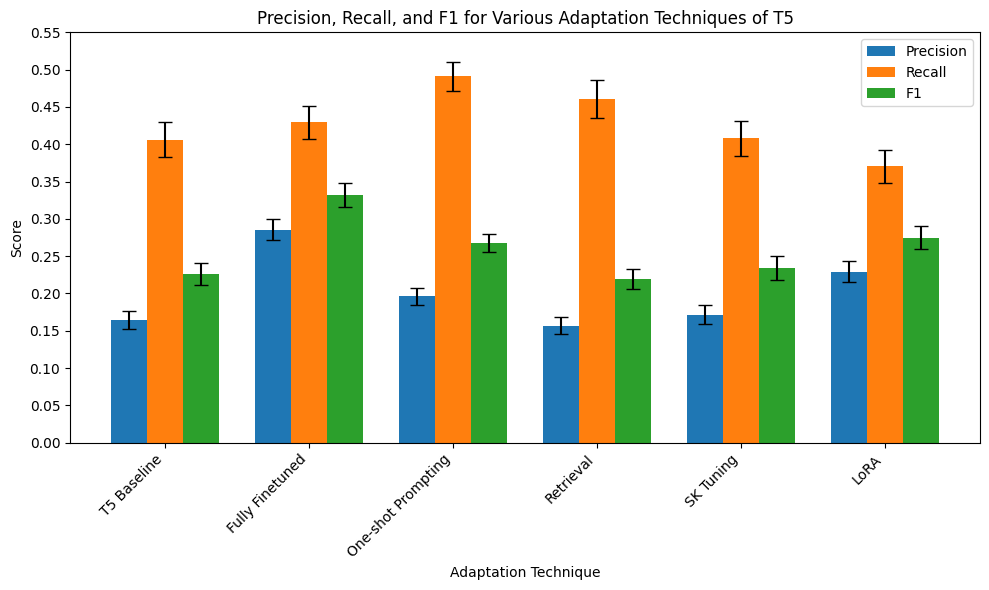

In [26]:
import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ['Precision', 'Recall', 'F1']

models = list(all_model_results.keys())
n_models = len(models)
n_metrics = len(metrics_to_plot)

means = np.zeros((n_metrics, n_models))
ci_lower = np.zeros((n_metrics, n_models))
ci_upper = np.zeros((n_metrics, n_models))

metric_names = list(metrics.keys())

for i, metric in enumerate(metrics_to_plot):
    metric_idx = metric_names.index(metric)
    for j, model in enumerate(models):
        mean, lower, upper, std = all_model_results[model][metric_idx]
        means[i, j] = mean
        ci_lower[i, j] = mean - lower
        ci_upper[i, j] = upper - mean

y_max = np.ceil((means + ci_upper).max() * 20) / 20

x = np.arange(n_models)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(n_metrics):
    ax.bar(x + i*width, means[i], width, yerr=[ci_lower[i], ci_upper[i]],
           capsize=5, label=metrics_to_plot[i])


ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_xlabel('Adaptation Technique')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 for Various Adaptation Techniques of T5')
ax.legend()

# Y-axis ticks every 0.05
ax.set_yticks(np.arange(0, y_max + 0.01, 0.05))
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


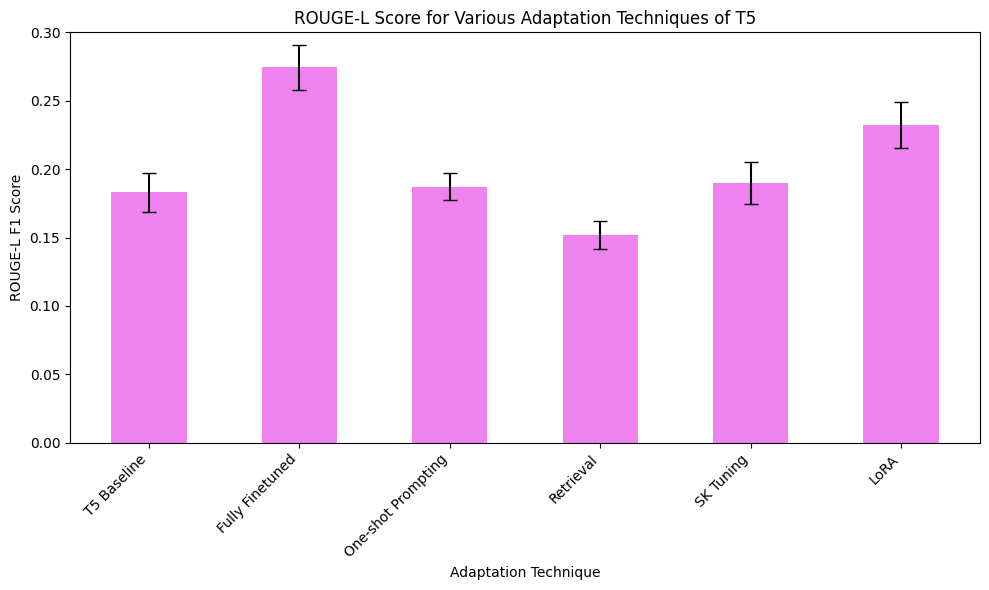

In [27]:
import matplotlib.pyplot as plt
import numpy as np

metric_to_plot = 'ROUGE-L F1'

models = list(all_model_results.keys())
n_models = len(models)

means = np.zeros(n_models)
ci_lower = np.zeros(n_models)
ci_upper = np.zeros(n_models)

metric_names = list(metrics.keys())
metric_idx = metric_names.index(metric_to_plot)

for j, model in enumerate(models):
    mean, lower, upper, std = all_model_results[model][metric_idx]
    means[j] = mean
    ci_lower[j] = mean - lower
    ci_upper[j] = upper - mean

y_max = np.ceil((means + ci_upper).max() * 20) / 20

x = np.arange(n_models)
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, means, width, yerr=[ci_lower, ci_upper], capsize=5, color='violet')

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_xlabel('Adaptation Technique')
ax.set_ylabel('ROUGE-L F1 Score')
ax.set_title('ROUGE-L Score for Various Adaptation Techniques of T5')

ax.set_yticks(np.arange(0, y_max + 0.01, 0.05))
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


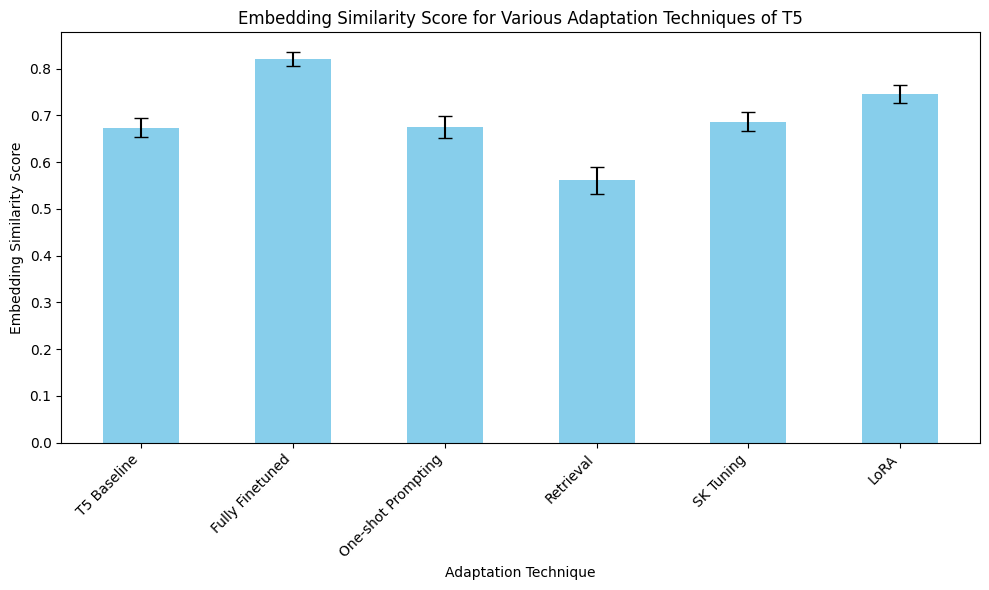

In [28]:
import matplotlib.pyplot as plt
import numpy as np

metric_to_plot = 'Embedding Similarity'

models = list(all_model_results.keys())
n_models = len(models)

means = np.zeros(n_models)
ci_lower = np.zeros(n_models)
ci_upper = np.zeros(n_models)

metric_names = list(metrics.keys())
metric_idx = metric_names.index(metric_to_plot)

for j, model in enumerate(models):
    # Each entry is (mean, ci_lower, ci_upper, std)
    mean, lower, upper, std = all_model_results[model][metric_idx]
    means[j] = mean
    ci_lower[j] = mean - lower
    ci_upper[j] = upper - mean

y_max = np.ceil((means + ci_upper).max() * 20) / 20

x = np.arange(n_models)
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, means, width, yerr=[ci_lower, ci_upper], capsize=5, color='skyblue')

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_xlabel('Adaptation Technique')
ax.set_ylabel('Embedding Similarity Score')
ax.set_title('Embedding Similarity Score for Various Adaptation Techniques of T5')

plt.tight_layout()
plt.show()